In [1]:
import meep as mp
import gdspy
import numpy as np
import matplotlib.pyplot as plt


In [2]:

# Load GDS
gds_path = "/mnt/c/Users/ku/jonah/samplemaker-master/samplemaker-master/test_franzi_2_confused.gds"
gds_lib = gdspy.GdsLibrary()
gds_lib.read_gds(gds_path)

print("Cells in library:", list(gds_lib.cells.keys()))

# Function to collect polygons from a cell (recursively) by layer
def collect_polygons(cell, layers=(0,1)):
    polys = []
    
    # Get polygons grouped by (layer, datatype)
    polygons_by_spec = cell.get_polygons(by_spec=True)
    
    for (layer, datatype), poly_list in polygons_by_spec.items():
        if layer in layers:
            polys.extend(poly_list)
    
    # Recursively traverse references
    for ref in cell.references:
        ref_cell = gds_lib.cells[ref.ref_cell.name]
        polys.extend(collect_polygons(ref_cell, layers))
    
    return polys

# Pick a top-level cell
top_cell = list(gds_lib.cells.values())[1]

# Collect only polygons on layer 5
polygons = collect_polygons(top_cell, layers=(5,))
print(f"Collected {len(polygons)} polygons from layer 5")


Cells in library: ['DISKRESONATOR_0001', 'CELL00']
Collected 4 polygons from layer 5


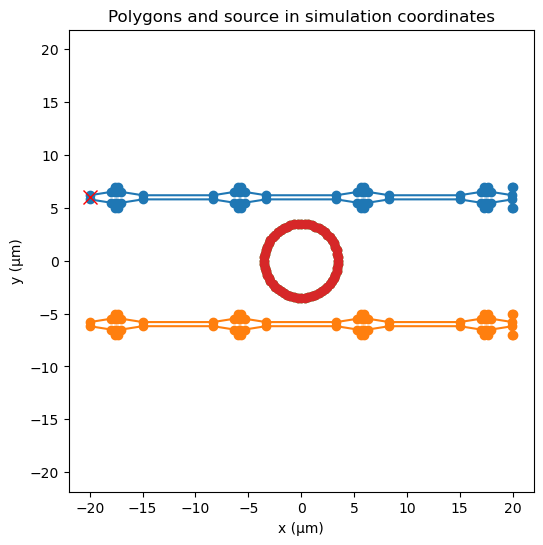

In [3]:
# Compute bounding box of polygons
all_points = np.vstack(polygons)
x_min, x_max = all_points[:,0].min(), all_points[:,0].max()
y_min, y_max = all_points[:,1].min(), all_points[:,1].max()

# Define cell with some padding
pad = 2
sx = (x_max - x_min) + 2*pad
sy = (y_max - y_min) + 2*pad
cell = mp.Vector3(sx, sy, 0)

# Shift origin so that (0,0) is cell center
x_center = 0.5*(x_min + x_max)
y_center = 0.5*(y_min + y_max)

# Rebuild geometry in centered coordinates
geometry = []
for poly in polygons:
    vertices = [mp.Vector3(x - x_center, y - y_center) for x,y in poly]
    geometry.append(mp.Prism(vertices=vertices, height=mp.inf, material=mp.Medium(epsilon=12)))

# Now place the source at physical (0,12) directly
source_x = 0- x_center
source_y = 12 - y_center
sources = [mp.Source(mp.GaussianSource(frequency=0.9881, fwidth=0.1),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0,2,0))]

# -----------------------------
# Plot the layout and source
# -----------------------------
plt.figure(figsize=(6,6))
for poly in polygons:
    shifted_poly = poly - np.array([x_center, y_center])
    plt.plot(shifted_poly[:,0], shifted_poly[:,1], '-o', label='Polygon')
plt.plot(source_x, source_y, 'rx', markersize=10, label='Source')

plt.axis('equal')
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.title("Polygons and source in simulation coordinates")
plt.show()


In [ ]:
# ------------------------
# Simulation parameters
# ------------------------

fmin = 0.2    # minimum frequency in Meep units
fmax = 1.8    # maximum frequency
df   = fmax - fmin
nfreq = 500   # number of frequency points

# Simulation cell
pml_layers = [mp.PML(1.0)]
resolution = 11

# Broadband Gaussian source (covers fmin–fmax)
sources = [mp.Source(mp.GaussianSource(frequency=(fmin+fmax)/2, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, 0, 0))]

sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

# ------------------------
# Flux monitors
# ------------------------

flux_x = 0
flux_y = 2

flux_region = mp.FluxRegion(center=mp.Vector3(flux_x, flux_y),
                            size=mp.Vector3(0, 0.5, 0))  # full waveguide width

# Transmission flux monitor: centered at (fmin+fmax)/2, width = df
trans_flux = sim.add_flux((fmin+fmax)/2, df, nfreq, flux_region)

# Input flux monitor (for normalization)
input_flux_region = mp.FluxRegion(center=mp.Vector3(source_x, source_y),
                                  size=mp.Vector3(0, 0, 0))
input_flux = sim.add_flux((fmin+fmax)/2, df, nfreq, input_flux_region)

# ------------------------
# Run the simulation
# ------------------------
sim.run(until_after_sources=mp.stop_when_fields_decayed(
    30, mp.Ez, mp.Vector3(flux_x, flux_y), 1e-2))

# ------------------------
# Get transmission spectrum
# ------------------------
frequencies = np.array(mp.get_flux_freqs(trans_flux))   # freq points from 0.6–1.2
transmission = np.array(mp.get_fluxes(trans_flux))

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10,6))
plt.plot(frequencies, transmission, label="Transmission")
plt.xlabel("Frequency (1/µm)")
plt.ylabel("Transmission")
plt.title("Waveguide Transmission Spectrum")
plt.legend()
plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.00640512 s
Working in 2D dimensions.
Computational cell is 44 x 18 x 0 with resolution 10
     prism, center = (0.94981,6,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 84 vertices:


          (20,6.982,0)
          (19.996,6.982,0)
          (19.996,6.195,0)
          (17.996,6.51,0)
          (17.581,6.51,0)
          (17.581,6.852,0)
          (17.647,6.982,0)
          (17.344,6.982,0)
          (17.411,6.852,0)
          (17.411,6.51,0)
          (16.996,6.51,0)
          (14.996,6.195,0)
          (8.33,6.195,0)
          (6.33,6.51,0)
          (5.915,6.51,0)
          (5.915,6.852,0)
          (5.981,6.982,0)
          (5.678,6.982,0)
          (5.745,6.852,0)
          (5.745,6.51,0)
          (5.33,6.51,0)
          (3.33,6.195,0)
          (-3.336,6.195,0)
          (-5.336,6.51,0)
          (-5.751,6.51,0)
          (-5.751,6.852,0)
          (-5.685,6.982,0)
          (-5.988,6.982,0)
          (-5.921,6.852,0)
          (-5.921,6.51,0)
          (-6.336,6.51,0)
          (-8.336,6.195,0)
          (-15,6.195,0)
          (-17,6.51,0)
          (-17.415,6.51,0)
          (-17.415,6.852,0)
          (-17.349,6.982,0)
          (-17.652,6.982,0)
        

RuntimeError: meep: Could not determine normal direction for given grid_volume.

Maximum transmission: 1.4568 at frequency 0.9881 (1/µm)


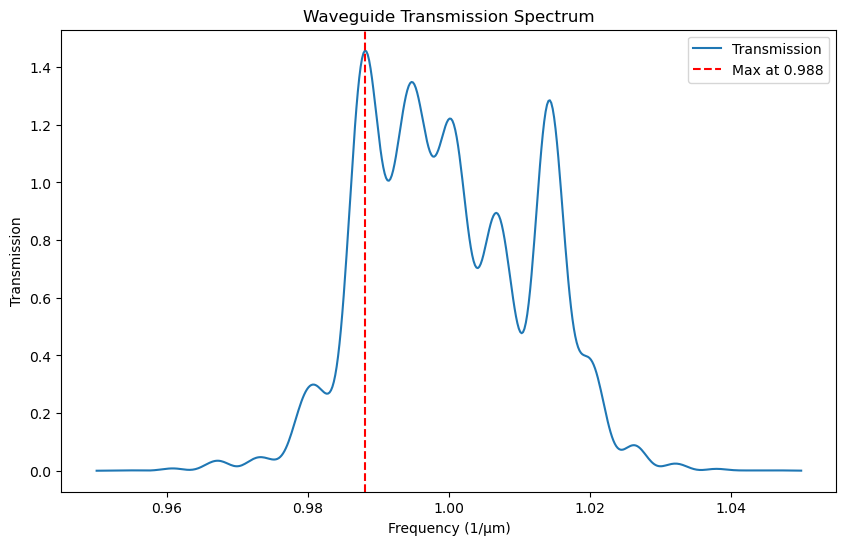

In [18]:
# ------------------------
# Get transmission spectrum
# ------------------------
frequencies = np.array(mp.get_flux_freqs(trans_flux))   # freq points from 0.6–1.2
transmission = np.array(mp.get_fluxes(trans_flux))

# Find max transmission and corresponding frequency
max_idx = np.argmax(transmission)
max_val = transmission[max_idx]
max_freq = frequencies[max_idx]

print(f"Maximum transmission: {max_val:.4f} at frequency {max_freq:.4f} (1/µm)")

# ------------------------
# Plot
# ------------------------
plt.figure(figsize=(10,6))
plt.plot(frequencies, transmission, label="Transmission")
plt.axvline(max_freq, color='red', ls='--', label=f"Max at {max_freq:.3f}")
plt.xlabel("Frequency (1/µm)")
plt.ylabel("Transmission")
plt.title("Waveguide Transmission Spectrum")
plt.legend()
plt.show()

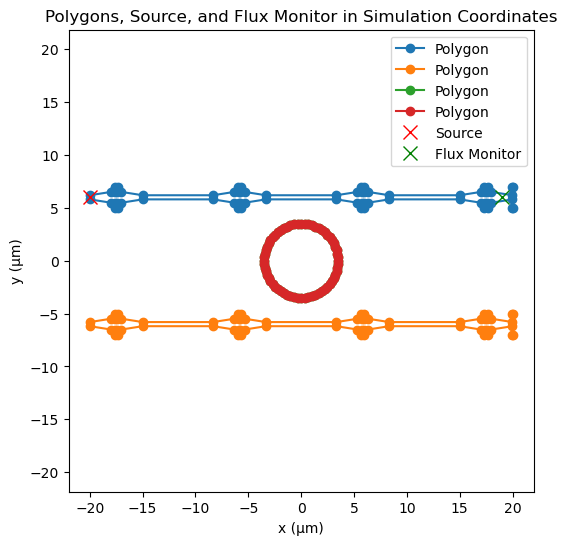

In [5]:
# -----------------------------
# Plot the layout, source, and flux monitor
# -----------------------------
plt.figure(figsize=(6,6))

# Plot polygons
for poly in polygons:
    shifted_poly = poly - np.array([x_center, y_center])
    plt.plot(shifted_poly[:,0], shifted_poly[:,1], '-o', label='Polygon')

# Plot source
plt.plot(source_x, source_y, 'rx', markersize=10, label='Source')

# Plot flux monitor
flux_x = source_x + 39  # 39 µm to the right of source
flux_y = source_y
plt.plot(flux_x, flux_y, 'gx', markersize=10, label='Flux Monitor')

plt.axis('equal')
plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.title("Polygons, Source, and Flux Monitor in Simulation Coordinates")
plt.legend()
plt.show()


In [20]:
pml_layers = [mp.PML(1.0)]
resolution = 40

sim = mp.Simulation(cell_size=cell,
                    geometry=geometry,
                    sources=sources,
                    boundary_layers=pml_layers,
                    resolution=resolution)

# Store Ez snapshots
ez_data = []
def store_fields(sim):
    ez_data.append(sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez))

sim.run(mp.at_every(2, store_fields), until=100)


-----------
Initializing structure...
time for choose_chunkdivision = 0.00402188 s
Working in 2D dimensions.
Computational cell is 44 x 17.975 x 0 with resolution 40
     prism, center = (0.94981,6,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 84 vertices:
          (20,6.982,0)
          (19.996,6.982,0)
          (19.996,6.195,0)
          (17.996,6.51,0)
          (17.581,6.51,0)
          (17.581,6.852,0)
          (17.647,6.982,0)
          (17.344,6.982,0)
          (17.411,6.852,0)
          (17.411,6.51,0)
          (16.996,6.51,0)
          (14.996,6.195,0)
          (8.33,6.195,0)
          (6.33,6.51,0)
          (5.915,6.51,0)
          (5.915,6.852,0)
          (5.981,6.982,0)
          (5.678,6.982,0)
          (5.745,6.852,0)
          (5.745,6.51,0)
          (5.33,6.51,0)
          (3.33,6.195,0)
          (-3.336,6.195,0)
          (-5.336,6.51,0)
          (-5.751,6.51,0)
          (-5.751,6.852,0)
          (-5.685,6.982,0)
          (-5.98

FloatProgress(value=0.0, description='0% done ')

Meep progress: 2.7750000000000004/100.0 = 2.8% done in 4.0s, 140.6s to go
on time step 222 (time=2.775), 0.0180234 s/step
Meep progress: 5.675000000000001/100.0 = 5.7% done in 8.0s, 133.3s to go
on time step 454 (time=5.675), 0.0172513 s/step
Meep progress: 8.1875/100.0 = 8.2% done in 12.0s, 134.8s to go
on time step 656 (time=8.2), 0.0198827 s/step
Meep progress: 10.9625/100.0 = 11.0% done in 16.0s, 130.1s to go
on time step 878 (time=10.975), 0.0180369 s/step
Meep progress: 14.0/100.0 = 14.0% done in 20.1s, 123.4s to go
on time step 1120 (time=14), 0.0167116 s/step
Meep progress: 17.05/100.0 = 17.1% done in 24.1s, 117.2s to go
on time step 1364 (time=17.05), 0.0164093 s/step
Meep progress: 19.962500000000002/100.0 = 20.0% done in 28.1s, 112.6s to go
on time step 1597 (time=19.9625), 0.0171758 s/step
Meep progress: 22.762500000000003/100.0 = 22.8% done in 32.1s, 108.9s to go
on time step 1821 (time=22.7625), 0.01788 s/step
Meep progress: 25.6625/100.0 = 25.7% done in 36.1s, 104.6s to 

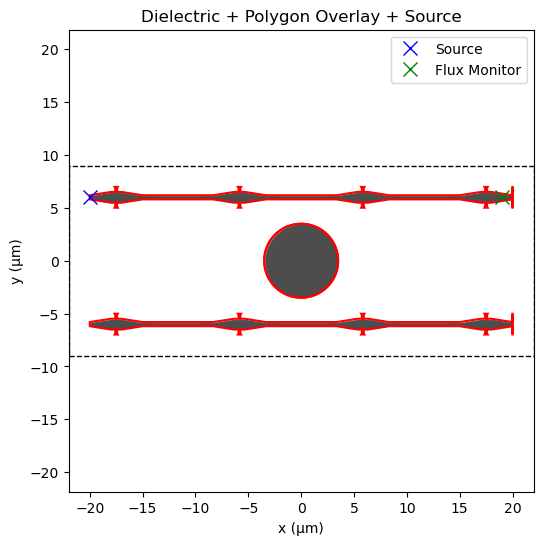

In [9]:

# Assume polygons, x_center, y_center, cell, source_x, source_y are already defined

# Get dielectric from MEEP
eps = sim.get_array(center=mp.Vector3(0,0),  # center at simulation origin
                    size=cell,
                    component=mp.Dielectric)

plt.figure(figsize=(6,6))

# Plot dielectric as background
plt.imshow(eps.T, cmap='Greys', origin='lower',
           extent=[-cell.x/2, cell.x/2, -cell.y/2, cell.y/2],
           alpha=0.7)

# Overlay polygons (shifted using centered coordinates)
for poly in polygons:
    shifted_poly = poly - np.array([x_center, y_center])
    plt.fill(shifted_poly[:,0], shifted_poly[:,1], facecolor='none',
             edgecolor='red', linewidth=1.5)

# Plot source
plt.plot(source_x, source_y, 'bx', markersize=10, label='Source')

# Plot flux monitor
flux_x = source_x + 39   # 39 µm downstream
flux_y = source_y
plt.plot(flux_x, flux_y, 'gx', markersize=10, label='Flux Monitor')

# Plot simulation cell boundary
plt.gca().add_patch(plt.Rectangle((-cell.x/2, -cell.y/2), cell.x, cell.y,
                                  fill=False, ls='--', edgecolor='black', linewidth=1))

plt.xlabel("x (µm)")
plt.ylabel("y (µm)")
plt.axis('equal')
plt.title("Dielectric + Polygon Overlay + Source")
plt.legend()
plt.show()



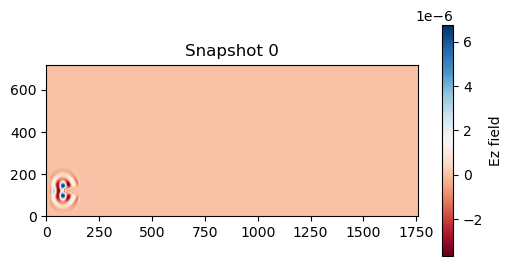

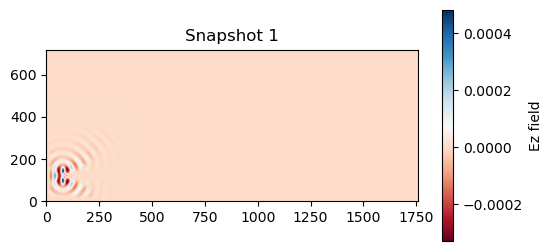

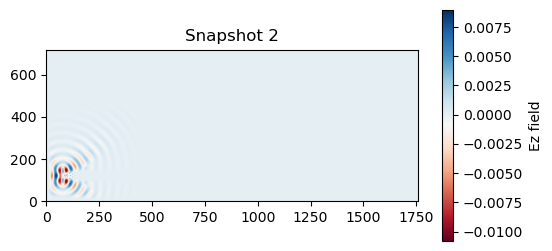

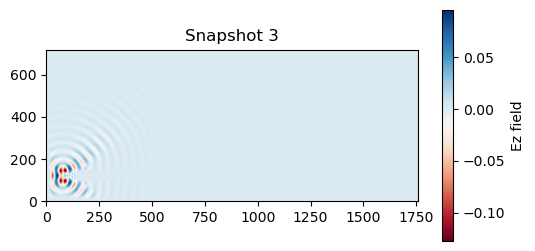

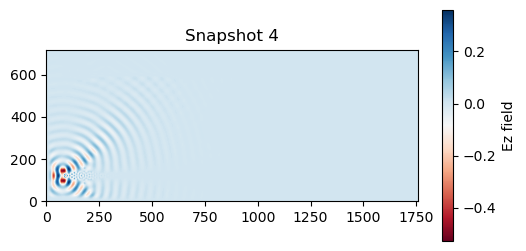

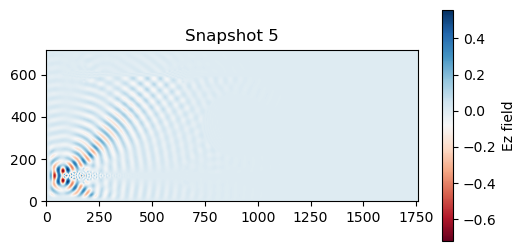

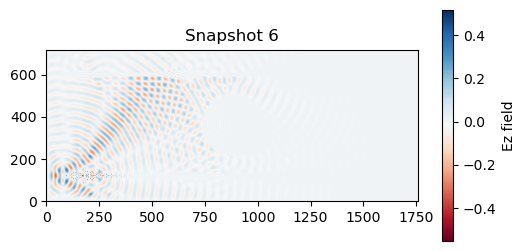

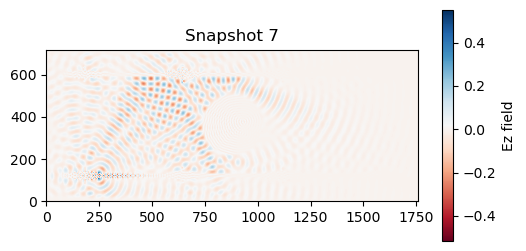

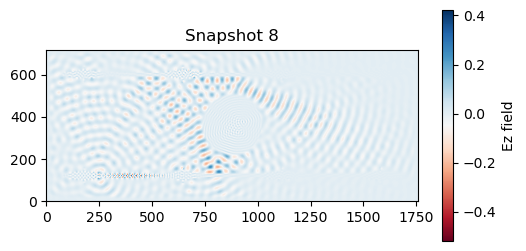

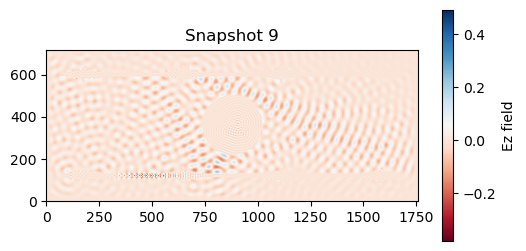

In [21]:
import matplotlib.pyplot as plt

for i, field in enumerate(ez_data[::5]):  # plot every 5 steps
    plt.figure(figsize=(6,3))
    plt.imshow(np.rot90(field), cmap="RdBu", origin="lower")
    plt.colorbar(label="Ez field")
    plt.title(f"Snapshot {i}")
    plt.show()


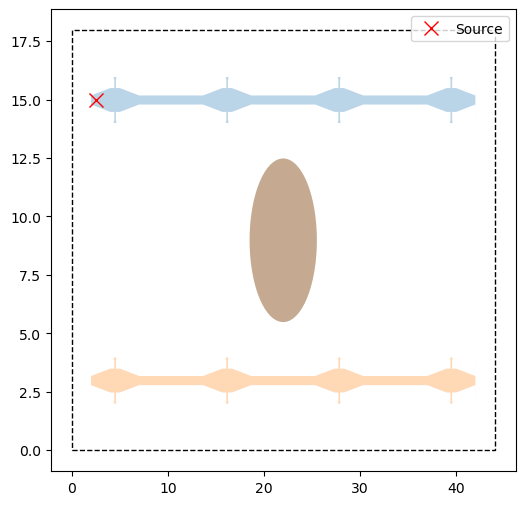

In [44]:
plt.figure(figsize=(6,6))
for poly in polygons:
    shifted_poly = poly - np.array([origin_x, origin_y])
    plt.fill(shifted_poly[:,0], shifted_poly[:,1], alpha=0.3)
plt.plot(source_x_meep, source_y_meep, 'rx', markersize=10, label='Source')
plt.gca().add_patch(plt.Rectangle((0,0), cell.x, cell.y, fill=False, ls="--"))
plt.legend()
plt.show()

In [45]:
print("Cell size:", cell)
print("Cell center:", x_center, y_center)
print("Source relative:", source_x, source_y)
print("Polygon x range:", x_min, x_max)
print("Polygon y range:", y_min, y_max)


Cell size: Vector3<44.0, 17.964, 0.0>
Cell center: 20.0 6.000000000000001
Source relative: -20.0 5.999999999999999
Polygon x range: 0.0 40.0
Polygon y range: -0.982 12.982000000000001
